<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/Consumer_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
%%capture 

!pip install jaxopt

In [44]:
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import jaxopt
from functools import partial 
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative

In [45]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [46]:
def utility_fn(scale, alpha_h, alpha_c, h, c): 
  return scale *h**alpha_h * c ** alpha_c

In [47]:

def implicit_fn(init_val, fn, c, x1):

  loss_fn = lambda x2: (fn(x1, x2) -c)**2

  def body_fn(val):
    return jnp.maximum(0.0001 , val - 0.0001*jax.grad(loss_fn)(val))

  def cond_fn(val):
    return loss_fn(val) > 1e-3

  z = jax.lax.while_loop(cond_fn, body_fn, init_val=init_val)
  return z 
  

def graph_indifference_curve(init_val, fn, c):
  x1s = jnp.linspace(.1, 1., 100)
  x2s = jax.vmap(partial(implicit_fn, init_val, fn, c))(x1s)
  return x1s, x2s

In [48]:
utility_fn_params = (10., .5, .5)
choice_params = (.1, 200.)
utility_fn(*utility_fn_params, *choice_params)

44.721359549995796

In [49]:
h0, c0 = graph_indifference_curve(100., partial(utility_fn, *utility_fn_params), 10.)
h1, c1 = graph_indifference_curve(100., partial(utility_fn, *utility_fn_params), 20.)
h2, c2 = graph_indifference_curve(100., partial(utility_fn, *utility_fn_params), 40.)

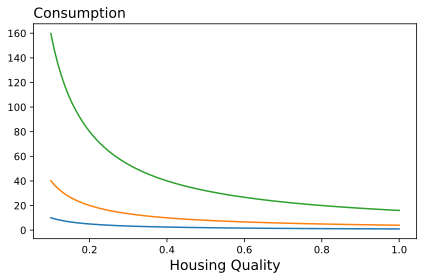

In [50]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(h0, c0)
plt.plot(h1, c1)
plt.plot(h2, c2)
plt.title('Consumption', loc='left', size=14)
plt.xlabel('Housing Quality', size=14)
fig.savefig("Indifference_Curves.png", label='png')
plt.show()

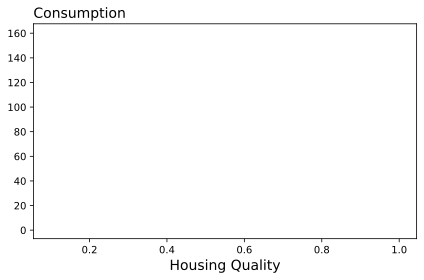

In [51]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(h0, c0, color='white')
plt.plot(h1, c1, color='white')
plt.plot(h2, c2, color='white')
plt.title('Consumption', loc='left', size=14)
plt.xlabel('Housing Quality', size=14)
fig.savefig("choice_set.png", label='png')
plt.show()

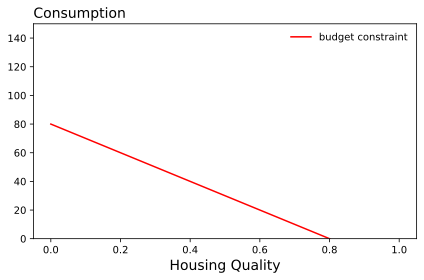

In [68]:
def housing_price_fn(h): 
  return 100

def max_consumption(income, housing_price_fn, h):
  return income - housing_price_fn(h)*h

def expenditure_fn(housing_price_fn, h, c):
  return housing_price_fn(h)*h + c

income = 80.
hs = jnp.linspace(0., 1., 100)
cs = jax.vmap(partial(max_consumption, income, housing_price_fn))(hs)

fig = plt.figure(dpi=300, tight_layout=True)
#plt.plot(h0, c0)
#plt.plot(h1, c1)
#plt.plot(h2, c2)
plt.plot(hs, cs, color='red', label='budget constraint')
plt.title('Consumption', loc='left', size=14)
plt.xlabel('Housing Quality', size=14)
plt.ylim(0, 150)
plt.legend(frameon=False)
fig.savefig("budget_constraint.png", label='png')
plt.show()

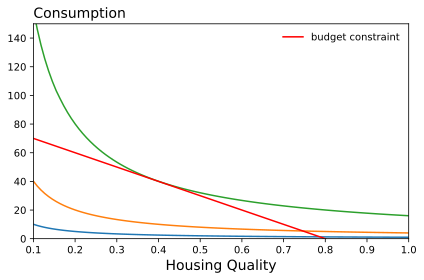

In [53]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(h0, c0)
plt.plot(h1, c1)
plt.plot(h2, c2)
plt.plot(hs, cs, color='red', label='budget constraint')
plt.title('Consumption', loc='left', size=14)
plt.xlabel('Housing Quality', size=14)
plt.ylim(0., 150)
plt.xlim(.1, 1.)
plt.legend(frameon=False)
fig.savefig("optimal_bundle.png", label='png')
plt.show()

In [62]:
def F(utility_fn, expenditure_fn, income, params):
  h, c, l = params
  
  a1, a2 = jax.grad(utility_fn, argnums=(0, 1))(h, c)
  b1, b2 = jax.grad(expenditure_fn, argnums=(0, 1))(h, c)

  return jnp.array([a1 - l*b1, a2-l*b2, income - expenditure_fn(h,c)])
  

In [69]:
f_root = partial(F, partial(utility_fn, *utility_fn_params), partial(expenditure_fn, housing_price_fn), income)

DeviceArray([-95.,   4., -21.], dtype=float64)

In [78]:
def newton_solver(f_root):

  g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))

  def body_fn(val):
    next_guess = g(val)
    return next_guess #jnp.array(jnp.maximum(next_guess[:-1], jnp.zeros(2)), next_guess[-1])

  def cond_fn(val):
    return jnp.linalg.norm(f_root(val)) > 1e-3

  z = jax.lax.while_loop(cond_fn, body_fn, init_val=jnp.ones(3))
  return z 

In [80]:
opt_bundle = newton_solver(f_root)

In [87]:
hs1, hs2 = graph_indifference_curve(100., partial(utility_fn, *utility_fn_params), utility_fn(*utility_fn_params, opt_bundle[0], opt_bundle[1]))

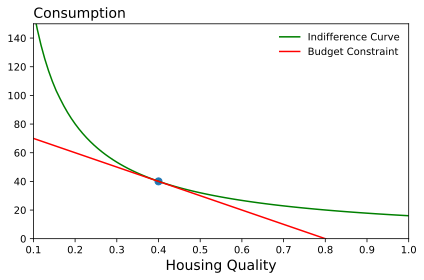

In [93]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(hs1, hs2, label='Indifference Curve', color='green')
plt.plot(hs, cs, color='red', label='Budget Constraint')
plt.scatter(opt_bundle[0], opt_bundle[1], s=50)
plt.title('Consumption', loc='left', size=14)
plt.xlabel('Housing Quality', size=14)
plt.ylim(0., 150)
plt.xlim(.1, 1.)
plt.legend(frameon=False)
fig.savefig("optimal_bundle2.png", label='png')
plt.show()

In [101]:
def find_optimal_bundle(scale, alpha_h, alpha_c, income):
  f_root = partial(F, partial(utility_fn, scale, alpha_h, alpha_c,), partial(expenditure_fn, housing_price_fn), income)
  opt_bundle = newton_solver(f_root)
  return opt_bundle

In [119]:
incomes = jnp.linspace(30, 130, 10)
opt_bundles1 = jax.vmap(partial(find_optimal_bundle, *utility_fn_params))(incomes)
opt_bundles2 = jax.vmap(partial(find_optimal_bundle, utility_fn_params[0]*2, utility_fn_params[1]-0.1, utility_fn_params[2]))(incomes)
opt_bundles3 = jax.vmap(partial(find_optimal_bundle, utility_fn_params[0]*2, utility_fn_params[1]+.1, utility_fn_params[2]))(incomes)

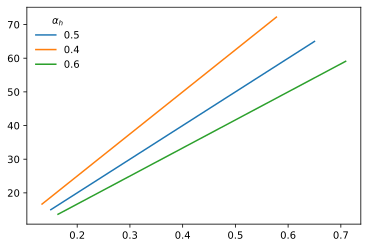

In [124]:
plt.plot(opt_bundles1[:,0], opt_bundles1[:,1], label =utility_fn_params[1])
plt.plot(opt_bundles2[:,0], opt_bundles2[:,1], label = utility_fn_params[1]-0.1)
plt.plot(opt_bundles3[:,0], opt_bundles3[:,1], label = utility_fn_params[1]+0.1)
plt.legend(frameon=False, title=r'$\alpha_h$')
plt.show()

In [110]:
opt_bundles2

DeviceArray([[ -430466.91      , 43046721.00000002,        0.        ],
             [ -430466.79888889, 43046721.00000002,        0.        ],
             [ -430466.68777778, 43046721.00000002,        0.        ],
             [ -430466.57666667, 43046721.00000002,        0.        ],
             [ -430466.46555556, 43046721.00000002,        0.        ],
             [ -430466.35444444, 43046721.00000002,        0.        ],
             [ -430466.24333333, 43046721.00000002,        0.        ],
             [ -430466.13222222, 43046721.00000002,        0.        ],
             [ -430466.02111111, 43046721.00000002,        0.        ],
             [ -430465.91      , 43046721.00000002,        0.        ]],            dtype=float64)